# Example use: Tidal Heating

The following example applies BHPwave to the modified tidal heating setup of https://arxiv.org/pdf/1910.07841. Please cite that reference as well as the bhpwave sources if this is of interest to you. 

Aside from BHPWave, LISATools will be used for part of the example

we start by loading useful modules. lisatools or other non-standard modules aside from bhpwave will only be imported later as needed.

In [148]:
#useful constants
from bhpwave.constants import *

#Geodesic motion
from bhpwave.trajectory.geodesic import *

#adiabatic inspiral, from precomputed trajectory data
from bhpwave.trajectory.inspiral import InspiralGenerator, TrajectoryData, Inspiral

#adiabatic inspiral with user costum input flux
from bhpwave.trajectory.inspiral import IntegrateInspiralGeneratorBase

#smaller functionality for processing how certain data was stored
from bhpwave.trajectory.inspiral import pn_flux_noprefactor, spin_of_chi
from bhpwave.spline import BicubicSpline

#waveform generation
from bhpwave.waveform import KerrCircularWaveform, KerrWaveform, KerrFrequencyWaveform

#useful standard python libraries
import matplotlib.pyplot as plt
import numpy as np
import time
import os

Before doing anything let us check some of the constants in BHPWave

In [179]:
#wikipedia constants
Gwiki=6.67430*10**(-11)
cwiki=299792458
Modotwiki=1.98847*10**30

print((Modot_GC1_to_S, Gwiki*Modotwiki/cwiki**3))
print(np.abs(Gwiki*Modotwiki/cwiki**3-Modot_GC1_to_S)/Modot_GC1_to_S)

#where does the difference come from to leading order?

#The measurement of G*Modot 
#is more accurately known than the individaul pieces
GModotwiki=1.32712442099*10**20

print((Modot_GC1_to_S, GModotwiki/cwiki**3))
print(np.abs( GModotwiki/cwiki**3-Modot_GC1_to_S)/Modot_GC1_to_S)

(4.925490949173312e-06, 4.925639893961039e-06)
3.02395820566828e-05
(4.925490949173312e-06, 4.925491025543576e-06)
1.5505107003446458e-08


## setting things up 

We now set-up some important functions and instantiate classes that will make the later results almost immediate

In [2]:
#path to notebook, take care with relative paths if you move from BHPWave directory
path_to_file = os.path.abspath("")

setting up the GR KerrWaveform with precomputed trajectory data

In [3]:
#inspiral trajectory
pathGR = path_to_file + "/data/trajectory.txt"
trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
inspiral_gen_GR = InspiralGenerator(trajectory_data=trajdata_GR)

#waveform
kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)

setting up the modified flux KerrWaveform with precomputed trajectory data

In [4]:
#inspiral trajectory
pathmod = path_to_file + "/data/trajectoryC1000000ppm.txt"
trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
inspiral_gen_mod_precomp = InspiralGenerator(trajectory_data=trajdata_mod)

#waveform
kerr_gen_td_mod_precomp = KerrWaveform(trajectory_data=trajdata_mod)

In order to have a costumized energy-flux for the trajectory, we need to provide it as a function of the orbital and central black hole parameters. 

Let us give some different options to compare.

Let us start with the quadrupole formula driving the energy-loss

In [131]:
#in geometric units 
#(see https://arxiv.org/pdf/1310.1528 for abundant details, especially if interested in higher orders)

def Edot_quadrupole(Omega,m1,m2):
    nu = m1*m2/(m1+m2)**2
    return 32./5.*nu**2*np.power(Omega,10./3.)

#input for BHPwave is actually normalized to leading PN power in omega and mass-ratio dependence
def Edot_quadrupole_norm(Omega,M,mratio):
    #let us keep the mass-ratio correction
    return 32./5./np.power(1.+mratio,2.)

#Finally, BHPWave uses a particular parameterization of the spin a and frequency Omega
#The translation is provided in the code:
def Edot_quadrupole_bhpwave(chi,alpha,M,mratio):
    a = spin_of_chi(chi)
    omega = omega_of_a_alpha(a, alpha)
    return Edot_quadrupole_norm(omega,M,mratio)

In [132]:
#Now set up the trajectory and waveform classes
integrator_quadrupole = IntegrateInspiralGeneratorBase(Edot_norm = Edot_quadrupole_bhpwave)
kerr_gen_td_quadrupole = KerrWaveform(trajectory_data=integrator_quadrupole)

In order to instead implement the modified flux setup of https://arxiv.org/pdf/1910.07841, we will use precomputed fluxes from the GR/Kerr case in the extreme-mass ratio limit. Here is a function to load those and return a spline of the data

In [133]:
#Want to interpolate the flux_data, we will do this a couple of times so define a function
def flux_to_norm_spline(Efluxraw):
    #reconstruct mesh (from how data was stored)
    #remark chi and alpha are functions of a and r
    chi_flux_array = np.linspace(0, 1, Efluxraw.shape[0])
    alpha_flux_array = np.linspace(0, 1, Efluxraw.shape[1])
    ALPHA_FLUX, CHI_FLUX = np.meshgrid(alpha_flux_array, chi_flux_array)
    SPIN_FLUX = spin_of_chi(CHI_FLUX)
    OMEGA_FLUX = omega_of_a_alpha(SPIN_FLUX, ALPHA_FLUX)

    #will want to normalize to PN flux
    Efluxraw_norm=Efluxraw/pn_flux_noprefactor(OMEGA_FLUX)
    flux_spline = BicubicSpline(chi_flux_array, alpha_flux_array, Efluxraw_norm, bc = 'E(3)')
    return flux_spline

For the total Kerr/GR energy-flux, we would then do the following

In [8]:
filename_flux = "/data/bhpwave_edot.npy"
path_to_file = os.path.abspath("")
flux_array = np.load(path_to_file + filename_flux)
edot_norm_spline = flux_to_norm_spline(flux_array)

#Now set up the trajectory and waveform classes
integrator_gr = IntegrateInspiralGeneratorBase(Edot_norm = edot_norm_spline)
kerr_gen_td_grcheck = KerrWaveform(trajectory_data=integrator_gr)

Instead for the setup of https://arxiv.org/pdf/1910.07841

In [9]:
filename_flux_H = "/data/bhpwave_edot_H.npy"
filename_flux_Infty = "/data/bhpwave_edot_Infty.npy"
flux_array_H = np.load(path_to_file + filename_flux_H)
flux_array_Infty = np.load(path_to_file + filename_flux_Infty)
edotH_norm_spline = flux_to_norm_spline(flux_array_H)
edotInfty_norm_spline = flux_to_norm_spline(flux_array_Infty)

def Edot_mod(chi,alpha,C):
    return edot_norm_spline(chi,alpha)-C*edotH_norm_spline(chi,alpha)

#Now set up the trajectory and waveform classes
integrator_mod = IntegrateInspiralGeneratorBase(Edot_norm = Edot_mod)
kerr_gen_td_mod = KerrWaveform(trajectory_data=integrator_mod)

As a sanity check, let us compare the splined values for the total flux compared to the sum of horizon flux and the energy radiated to asymptotic infinity

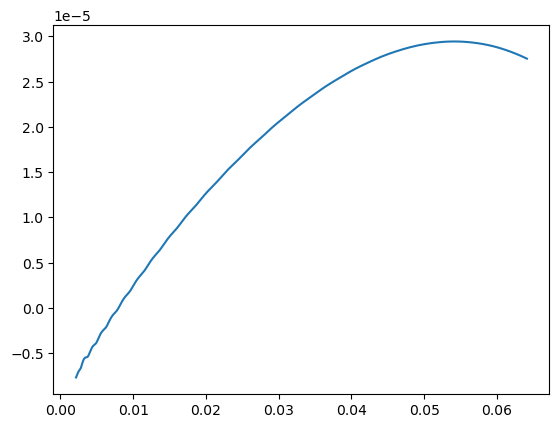

In [10]:
atest=0.9
chitest=chi_of_spin(atest)
rrange=np.linspace(60,6,1000)
omegarange=kerr_circ_geo_orbital_frequency(atest, rrange)
iscotest=kerr_isco_frequency(atest)
alpharange=alpha_of_omega_ISCO(omegarange, iscotest)

difftest=[edotH_norm_spline(chitest,alpha)+edotInfty_norm_spline(chitest,alpha)-edot_norm_spline(chitest,alpha) for alpha in alpharange]
plt.plot(omegarange,difftest)

In summary, we now have the following instantiated:

inspiral_gen_GR: GR/KERR inspiral trajectory from precomputed data 

kerr_gen_td_GR: GR/KERR waveforms from precomputed data 

inspiral_gen_mod_precomp: 'tidal heating' modified GR/KERR inspiral (precomputed data) 
kerr_gen_td_mod_precomp: 'tidal heating' modified GR/KERR waveforms 

integrator_gr: same as above but integrated on-fly with interpolated flux data
kerr_gen_td_grcheck: same as above but integrated on-fly with interpolated flux data

integrator_quadrupole: quadrupole flux driven inspiral trajectory

kerr_gen_td_quadrupole: quadrupole flux driven trajectory 'kludge' waveform

integrator_mod: 'tidal heating' modified GR/KERR inspiral

kerr_gen_td_mod: 'tidal heating' modified GR/KERR waveforms 

Let us put these to use and see what comes out!

## Evolution of the orbital radius

We study first unmodified inspiral. Giving in particular a comparison between the different values of the central black hole spin. We then compare with the quadrupole flux driven and tidal heating modified versions

For most of the examples below we keep the following parameters fixed

In [37]:
M=10**6 #mass of the primary in solar masses
mu=30 #secondary mass
p0=10 #initial radius in solar mass
dttraj = 60.0*60.0*24  # time steps in seconds
dt=dttraj
T = 1.5  # waveform duration in years

Ctest=1 #example tidal heating parameter

To save us some repitition down the line

In [65]:
def inspirals_for_arange(a,inspiral_gen,args=[]):
    inspirals=list()
    for aa in a:
        inspiral = inspiral_gen(M,mu,aa,p0,dt,T,*args)
        inspirals.append(inspiral)
    return (a, inspirals)

In [39]:
avalues = [0.3,0.5,0.8,0.998]
inspirals_GR = inspirals_for_arange(avalues,inspiral_gen_GR)[1]

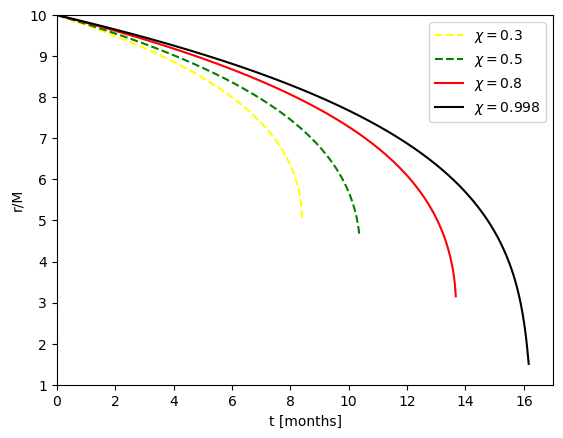

In [40]:
#remark output time in solar masses
labellist=[f'$\\chi = {aa}$' for aa in avalues]
stylelist=['' for ll in labellist]
colorlist=['' for ll in labellist]


#for easy comparison with https://arxiv.org/pdf/1910.07841
if len(stylelist)>3:
    stylelist[0]='dashed'
    stylelist[1]='dashed'
    stylelist[2]='-'
    stylelist[3]='-'

if len(colorlist)>3:
    colorlist[0]='yellow'
    colorlist[1]='green'
    colorlist[2]='red'
    colorlist[3]='black'

xmin = 0
xmax = 17
ymin= 1
ymax= 10

ax = plt.gca()
ii=0
for insp in inspirals_GR:

    itime=insp.time
    iradius=insp.radius
    
    ax.plot(Modot_GC1_to_S*M*itime/60./60./24./30.,iradius,label=labellist[ii],color=colorlist[ii],linestyle=stylelist[ii])
    plt.xlabel("t [months]")
    plt.ylabel("r/M")
    ii=ii+1
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend()
plt.show()

Let us now compare for different driving fluxes

In [41]:
def inspirals_for_genrange(a,inspiral_generators,args):
    inspirals=list()
    ii=0
    for inspiral_gen in inspiral_generators:
        inspiral = inspiral_gen(M,mu,a,p0,dt,T,*args[ii])
        inspirals.append(inspiral)
        ii=ii+1
    return (a, inspirals)

In [49]:
generators = [inspiral_gen_GR, integrator_quadrupole, integrator_mod]
#remark, let us use the emri version of the quadrupole, is
args=[[],[1.,0],[Ctest]]
#but we use
args=[[],[M+mu,mu/M],[Ctest]]

In [57]:
a = 0.998
inspirals = inspirals_for_genrange(a,generators,args)

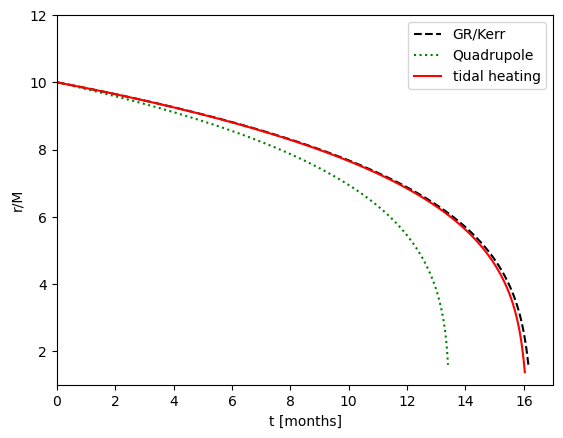

In [58]:
#remark output time in solar masses
labellist=['' for aa in avalues]
stylelist=['' for ll in labellist]
colorlist=['' for ll in labellist]

if len(labellist)>2:
    labellist[0]='GR/Kerr'
    labellist[1]='Quadrupole'
    labellist[2]='tidal heating'

if len(stylelist)>2:
    stylelist[0]='dashed'
    stylelist[1]='dotted'
    stylelist[2]='-'

if len(colorlist)>2:
    colorlist[0]='black'
    colorlist[1]='green'
    colorlist[2]='red'

xmin = 0
xmax = 17
ymin= 1
ymax= 12

ax = plt.gca()
ii=0
for insp in inspirals[1]:

    itime=insp.time
    iradius=insp.radius
    
    ax.plot(Modot_GC1_to_S*M*itime/60./60./24./30.,iradius,label=labellist[ii],color=colorlist[ii],linestyle=stylelist[ii])
    plt.xlabel("t [months]")
    plt.ylabel("r/M")
    ii=ii+1
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend()
plt.show()

Let us check the same in the earlier inspiral, non-spinning

In [52]:
p0=50
T=5
a = 0.0

generators = [inspiral_gen_GR, integrator_quadrupole, integrator_mod]
args=[[],[M+mu,mu/M],[Ctest]]
inspirals = inspirals_for_genrange(a,generators,args)

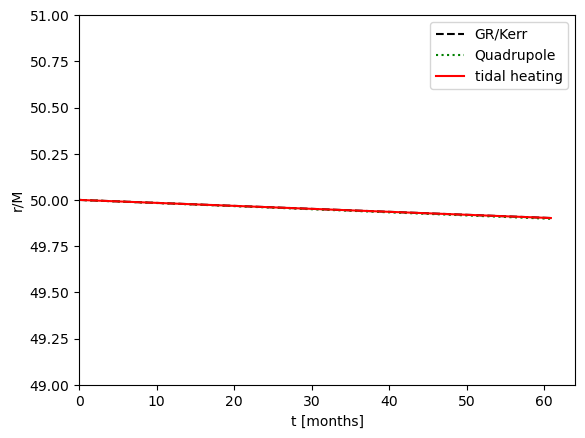

In [53]:
#remark output time in solar masses
labellist=['' for aa in avalues]
stylelist=['' for ll in labellist]
colorlist=['' for ll in labellist]

if len(labellist)>2:
    labellist[0]='GR/Kerr'
    labellist[1]='Quadrupole'
    labellist[2]='tidal heating'

if len(stylelist)>2:
    stylelist[0]='dashed'
    stylelist[1]='dotted'
    stylelist[2]='-'

if len(colorlist)>2:
    colorlist[0]='black'
    colorlist[1]='green'
    colorlist[2]='red'

xmin = 0
xmax = 64
ymin= 49
ymax= 51

ax = plt.gca()
ii=0
for insp in inspirals[1]:

    itime=insp.time
    iradius=insp.radius
    
    ax.plot(Modot_GC1_to_S*M*itime/60./60./24./30.,iradius,label=labellist[ii],color=colorlist[ii],linestyle=stylelist[ii])
    plt.xlabel("t [months]")
    plt.ylabel("r/M")
    ii=ii+1
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend()
plt.show()

In [75]:
#let's put back our standard system parameters

M=10**6 #mass of the primary in solar masses
mu=30 #mass ratio
p0=10 #initial radius in solar mass
dttraj = 60.  # time steps in seconds
dt=dttraj
T = 1.5  # waveform duration in years

Ctest=1 #example tidal heating parameter

args=[[],[M+mu,mu/M],[Ctest]]

## Evolution of the phase difference 

In [76]:
avalues = [0.3,0.5,0.8,0.998]
inspirals_GR = inspirals_for_arange(avalues,inspiral_gen_GR,args[0])[1]
inspirals_quad = inspirals_for_arange(avalues,integrator_quadrupole,args[1])[1]
inspirals_mod = inspirals_for_arange(avalues,integrator_mod,args[2])[1]

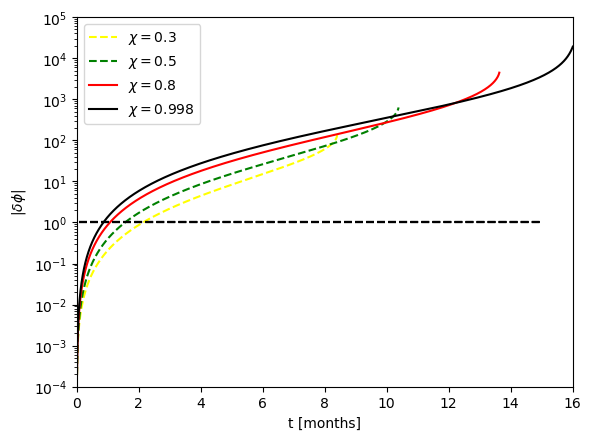

In [77]:
###gr v tidal heating

#remark output time in solar masses
labellist=[f'$\\chi = {aa}$' for aa in avalues]
stylelist=['' for ll in labellist]
colorlist=['' for ll in labellist]


#for easy comparison with https://arxiv.org/pdf/1910.07841
if len(stylelist)>3:
    stylelist[0]='dashed'
    stylelist[1]='dashed'
    stylelist[2]='-'
    stylelist[3]='-'

if len(colorlist)>3:
    colorlist[0]='yellow'
    colorlist[1]='green'
    colorlist[2]='red'
    colorlist[3]='black'

xmin = 0
xmax = 16
ymin= 10**-4
ymax= 10**5

ax = plt.gca()
ii=0
for insp in inspirals_GR:

    itime=insp.time
    itimemod=inspirals_mod[ii].time
    
    imax=min(len(itime),len(itimemod))
    dphase=2*np.abs(insp.phase[:imax]-inspirals_mod[ii].phase[:imax])
    
    ax.semilogy(Modot_GC1_to_S*M*itime[:imax]/60./60./24./30.,dphase,label=labellist[ii],color=colorlist[ii],linestyle=stylelist[ii])
    plt.hlines(1, -1, 15,colors='black',linestyles='dashed')
    plt.xlabel("t [months]")
    plt.ylabel(r"$|\delta \phi|$")
    ii=ii+1
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend()
plt.show()

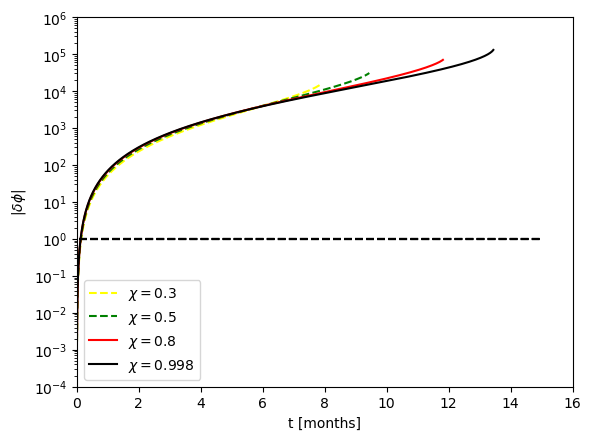

In [79]:
###gr v tidal quadrupole

#remark output time in solar masses
labellist=[f'$\\chi = {aa}$' for aa in avalues]
stylelist=['' for ll in labellist]
colorlist=['' for ll in labellist]


#for easy comparison with https://arxiv.org/pdf/1910.07841
if len(stylelist)>3:
    stylelist[0]='dashed'
    stylelist[1]='dashed'
    stylelist[2]='-'
    stylelist[3]='-'

if len(colorlist)>3:
    colorlist[0]='yellow'
    colorlist[1]='green'
    colorlist[2]='red'
    colorlist[3]='black'

xmin = 0
xmax = 16
ymin= 10**-4
ymax= 10**6

ax = plt.gca()
ii=0
for insp in inspirals_GR:

    itime=insp.time
    itimemod=inspirals_quad[ii].time
    
    imax=min(len(itime),len(itimemod))
    dphase=2*np.abs(insp.phase[:imax]-inspirals_quad[ii].phase[:imax])
    
    ax.semilogy(Modot_GC1_to_S*M*itime[:imax]/60./60./24./30.,dphase,label=labellist[ii],color=colorlist[ii],linestyle=stylelist[ii])
    plt.hlines(1, -1, 15,colors='black',linestyles='dashed')
    plt.xlabel("t [months]")
    plt.ylabel(r"$|\delta \phi|$")
    ii=ii+1
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend()
plt.show()

Having compare both approaches, let us now compare final phase as a function of the tidal heating parameter C

In [81]:
#function to compare final phases
#normalized by mass-ratio

def deltaphifun(M,mu,a,p0,dt,T,inspref,inspmod,args):
    insmod=inspmod(M,mu,a,p0,dt,T,*args)
    insgr=inspref(M,mu,a,p0,dt,T)
    
    iphase=insgr.phase
    iphasemod=insmod.phase

    #gravitational wave phase
    return 2*(iphase[-1]-iphasemod[-1])*mu/M

In [83]:
deltaphifun(M,mu,0.998,p0,dt,T,inspiral_gen_GR,integrator_mod,[1])

0.36501865387007126

Text(0, 0.5, '$|\\Delta \\phi|\\times (\\frac{\\mu}{M})$')

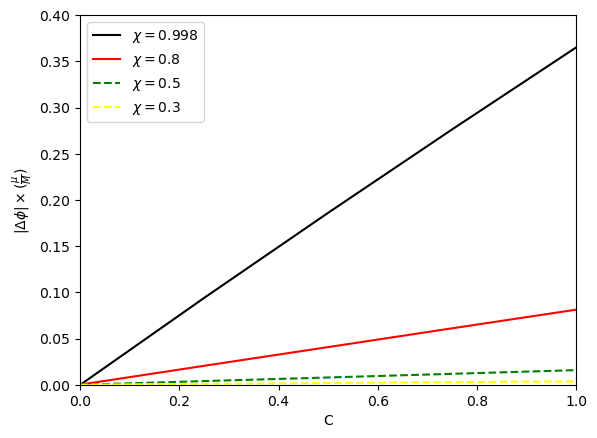

In [86]:
Cvalues=np.linspace(0,1,5)
deltphivalues998=Cvalues*0.
deltphivalues8=Cvalues*0.
deltphivalues5=Cvalues*0.
deltphivalues3=Cvalues*0.
ii=0
for C in Cvalues:
    deltphivalues998[ii] = deltaphifun(M,mu,0.998,p0,dt,T,inspiral_gen_GR,integrator_mod,[C])
    deltphivalues8[ii] = deltaphifun(M,mu,0.8,p0,dt,T,inspiral_gen_GR,integrator_mod,[C])
    deltphivalues5[ii] = deltaphifun(M,mu,0.5,p0,dt,T,inspiral_gen_GR,integrator_mod,[C])
    deltphivalues3[ii] = deltaphifun(M,mu,0.3,p0,dt,T,inspiral_gen_GR,integrator_mod,[C])
    ii=ii+1

plt.plot(Cvalues,deltphivalues998,label=r'$\chi = 0.998$',color='black')
plt.plot(Cvalues,deltphivalues8,label=r'$\chi = 0.8$',color='red')
plt.plot(Cvalues,deltphivalues5,label=r'$\chi = 0.5$',color='green',linestyle='dashed')
plt.plot(Cvalues,deltphivalues3,label=r'$\chi = 0.3$',color='yellow',linestyle='dashed')

xmin = 0.
xmax = 1.0
ymin= 0.0
ymax= 0.4
ax = plt.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.legend()
plt.xlabel("C")
plt.ylabel(r"$|\Delta \phi|\times (\frac{\mu}{M})$")

## A waveform

Let us now consider an example waveform associated to these inspirals

In [188]:
#Need also the extrinsic parameters

Ctest=1

#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 5.0  # time steps in seconds
T = 0.1 # waveform duration in years

a9=0.9
a7=0.7

injection_paramters7 = [M, mu, a7, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

injection_paramters9 = [M, mu, a9, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

In [189]:
#to note the difference between the waveforms for different spins
h7gr = kerr_gen_td_GR(*injection_paramters7)
h9gr = kerr_gen_td_GR(*injection_paramters9)

argsquad=[M+mu,mu/M]
h7quad =kerr_gen_td_quadrupole(*injection_paramters7,M+mu,mu/M)
h9quad = kerr_gen_td_quadrupole(*injection_paramters9,M+mu,mu/M)

argsmod=[Ctest]
h7mod =kerr_gen_td_mod(*injection_paramters7,Ctest)
h9mod = kerr_gen_td_mod(*injection_paramters9,Ctest)

t = np.arange(h7gr.shape[0])*dt
tstart=23.80*24.*60.*60.
tend=24.0*24.*60.*60.
ind=np.where((t>tstart) & (t<tend))

In [194]:
#as a check, how many cycles does one expect here?
inspgr7=inspiral_gen_GR(M,mu,a7,p0,dt,T)
time7=Modot_GC1_to_S*M*inspgr7.time
ind7 = np.where((time7>tstart) & (time7<tend))
print((integrator_gr.omega_of_a_r(a7,inspgr7.radius[ind7][0]),integrator_gr.omega_of_a_r(a7,inspgr7.radius[ind7][-1])))
gwomegaapprox=2*np.mean(integrator_gr.omega_of_a_r(a7,inspgr7.radius[ind7]))
print(1./Modot_GC1_to_S/M*gwomegaapprox/2./np.pi)
((tend-tstart)/Modot_GC1_to_S/M)*gwomegaapprox/2./np.pi

(0.03164804423249367, 0.03165426868274881)
0.0020454561773869126


35.345482745245846

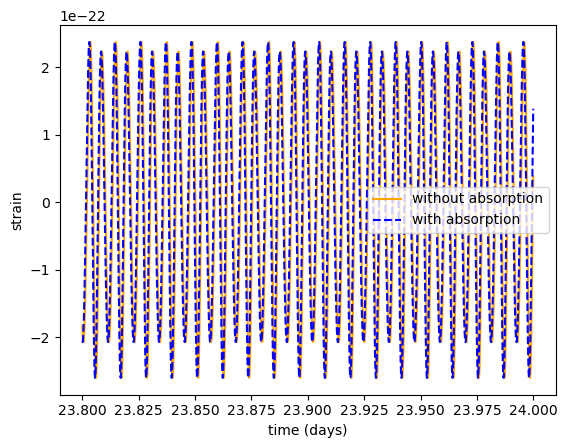

In [191]:
#GR v heating, spin of 0.7
plt.plot(t[ind]/24./60./60., h7gr.real[ind],label=r'without absorption',color='orange')
plt.plot(t[ind]/24./60./60., h7mod.real[ind],label=r'with absorption',color='blue',linestyle='dashed')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

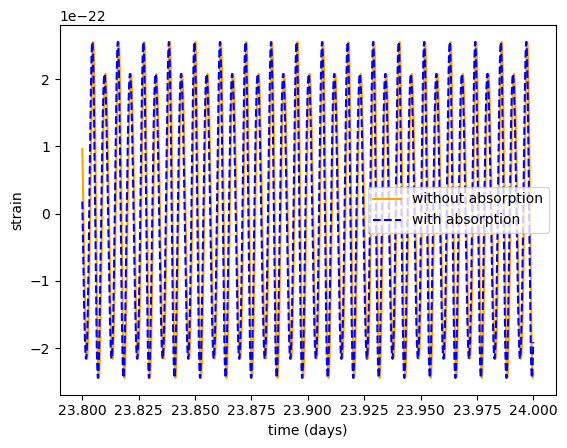

In [192]:
#GR v heating, spin of 0.7, same as above but different projection
plt.plot(t[ind]/24./60./60., h7gr.imag[ind],label=r'without absorption',color='orange')
plt.plot(t[ind]/24./60./60., h7mod.imag[ind],label=r'with absorption',color='blue',linestyle='dashed')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

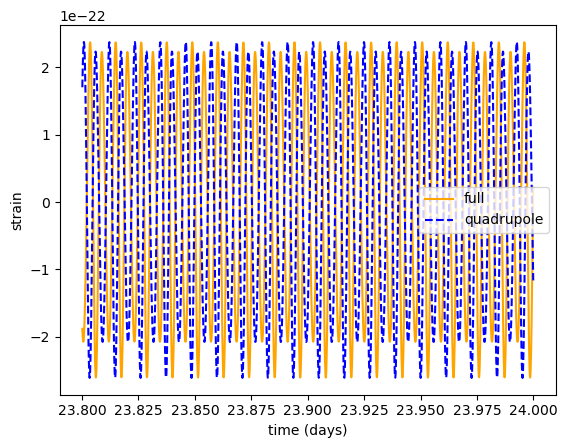

In [165]:
#GR v quadrupole, spin of 0.7
#why for quad here two arrays instead of complex?

plt.plot(t[ind]/24./60./60., h7gr.real[ind],label=r'full',color='orange')
plt.plot(t[ind]/24./60./60., h7quad[0][ind],label=r'quadrupole',color='blue',linestyle='dashed')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

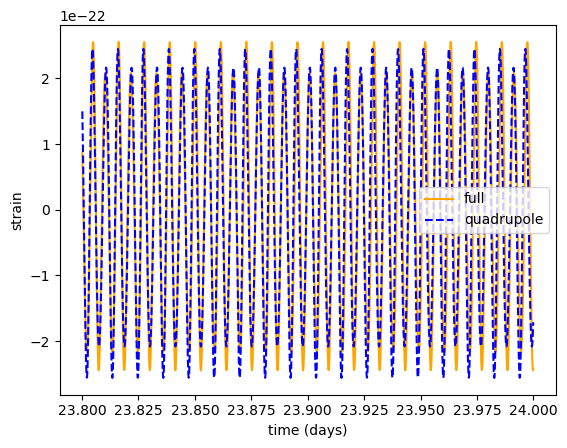

In [166]:
#GR v quadrupole, spin of 0.7, same as above but different polarization?
#why for quad here two arrays instead of complex?

plt.plot(t[ind]/24./60./60., h7gr.imag[ind],label=r'full',color='orange')
plt.plot(t[ind]/24./60./60., h7quad[1][ind],label=r'quadrupole',color='blue',linestyle='dashed')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

In [161]:
#as a check, how many cycles does one expect here?
inspgr9=inspiral_gen_GR(M,mu,a9,p0,dt,T)
time9=Modot_GC1_to_S*M*inspgr9.time
ind9 = np.where((time9>tstart) & (time9<tend))
print((integrator_gr.omega_of_a_r(a9,inspgr9.radius[ind9][0]),integrator_gr.omega_of_a_r(a9,inspgr9.radius[ind9][-1])))
gwomegaapprox=2*np.mean(integrator_gr.omega_of_a_r(a9,inspgr9.radius[ind9]))

((tend-tstart)/Modot_GC1_to_S/M)*gwomegaapprox/2./np.pi

(0.03138866902016838, 0.03139425660956482)


35.05547771892989

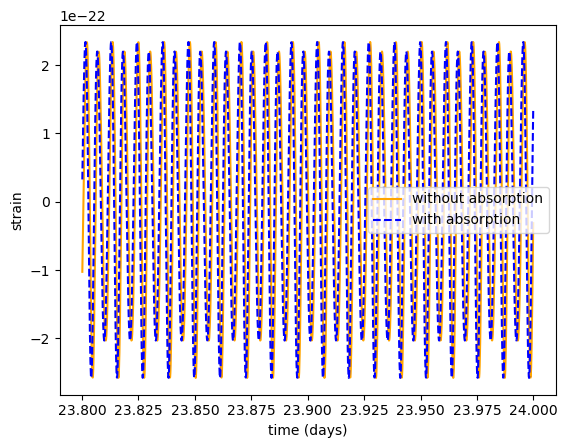

In [115]:
#GR v heating, spin of 0.9

plt.plot(t[ind]/24./60./60., h9gr.real[ind],label=r'without absorption',color='orange')
plt.plot(t[ind]/24./60./60., h9mod.real[ind],label=r'with absorption',color='blue',linestyle='dashed')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

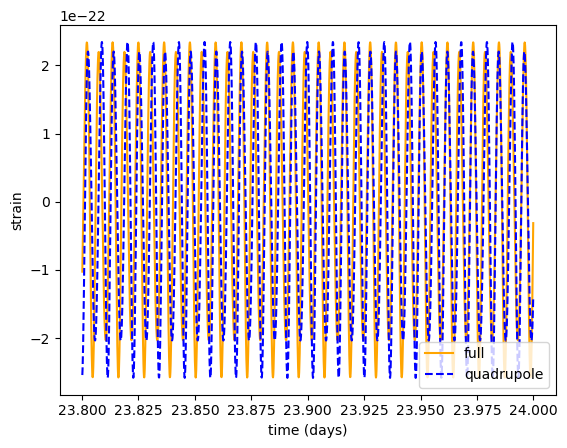

In [138]:
#GR v quadrupole, spin of 0.9
#why for quad here two arrays instead of complex?
plt.plot(t[ind]/24./60./60., h9gr.real[ind],label=r'full',color='orange')
plt.plot(t[ind]/24./60./60., h9quad[0][ind],label=r'quadrupole',color='blue',linestyle='dashed')
plt.xlabel("time (days)")
plt.ylabel("strain")
plt.legend()
plt.show()

## Let's transform to the frequency domain

See also quick tutorial notebook, we will simply use the 0.7 values of the waveforms
computed above, that means a very short stretch so one mainly sees the main harmonics of the local orbital frequency!


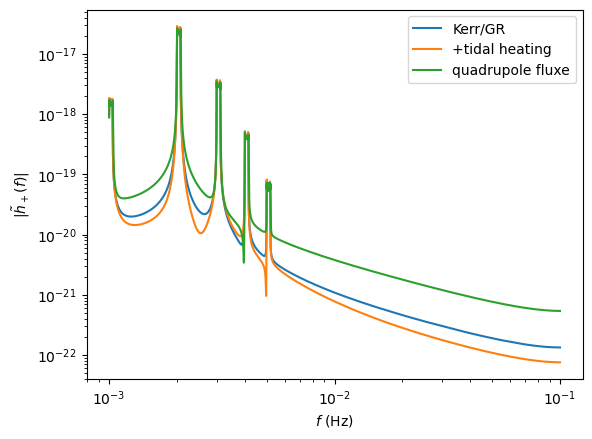

In [193]:
h7grdft = np.fft.rfft([h7gr.real, -h7gr.imag])*dt
h7moddft = np.fft.rfft([h7mod.real, -h7mod.imag])*dt
h7quaddft = np.fft.rfft([h7quad[0], -h7quad[1]])*dt
freq = np.fft.rfftfreq(h7gr.shape[0], d=dt)

ind=np.where((freq > 1e-3) & (freq <1e-1))

plt.loglog(freq[ind], np.abs(h7grdft[0])[ind], label = 'Kerr/GR')
plt.loglog(freq[ind], np.abs(h7moddft[0])[ind], label = '+tidal heating')
plt.loglog(freq[ind], np.abs(h7quaddft[0])[ind], label = 'quadrupole fluxe')
plt.ylabel("$|\\tilde{h}_+(f)|$")
plt.xlabel("$f$ (Hz)")
plt.legend()
plt.show()

Let's do the same for a longer evolution

In [195]:
#Need also the extrinsic parameters

Ctest=1

#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 60.0  # time steps in seconds
T = 1. # waveform duration in years

a=0.7

injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

#to note the difference between the waveforms for different spins
hgr = kerr_gen_td_GR(*injection_paramters)

hquad =kerr_gen_td_quadrupole(*injection_paramters,M+mu,mu/M)

hmod =kerr_gen_td_mod(*injection_paramters,Ctest)

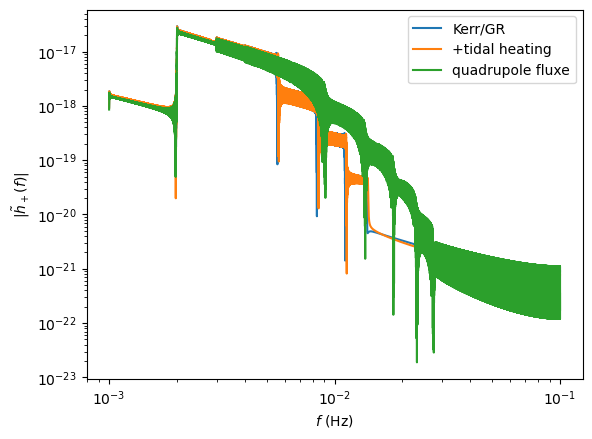

In [196]:
hgrdft = np.fft.rfft([hgr.real, -hgr.imag])*dt
hmoddft = np.fft.rfft([hmod.real, -hmod.imag])*dt
hquaddft = np.fft.rfft([hquad[0], -hquad[1]])*dt
freq = np.fft.rfftfreq(hgr.shape[0], d=dt)


ind=np.where((freq > 1e-3) & (freq <1e-1))

plt.loglog(freq[ind], np.abs(hgrdft[0])[ind], label = 'Kerr/GR')
plt.loglog(freq[ind], np.abs(hmoddft[0])[ind], label = '+tidal heating')
plt.loglog(freq[ind], np.abs(hquaddft[0])[ind], label = 'quadrupole fluxe')
plt.ylabel("$|\\tilde{h}_+(f)|$")
plt.xlabel("$f$ (Hz)")
plt.legend()
plt.show()

## Check against FEW 

Let us compare against what is possible with the Fast-EMRI Waveforms FEW

In [181]:
from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *

#note
print((Modot_GC1_to_S,MTSUN_SI))

(4.925490949173312e-06, 4.925491025873693e-06)


In [ ]:
#some test parameters

#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 1e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 12.05 # initial semi-latus rectum

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 1.0  # distance to source in Gpc

dt = 10.0  # time steps in seconds
T = 0.1 # waveform duration in years

#non-rotating
a=0.0

In [169]:
few_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")

In [171]:
# make sure we are using the same number of modes
specific_modes=kerr_gen_td_GR.select_modes(M,mu,a,p0,qS,phiS,qK,phiK,Phi_phi0,T=T,dt=dt, eps=1.e-5, pad_nmodes=True)

hF = few_wave(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,T=T,dt=dt,mode_selection=specific_modes)
hB = kerr_gen_td_GR(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,T=T,dt=dt,num_threads=16,select_modes=specific_modes)

## Mismatches 

To get a better sense of how different the waveforms become, let us compute some mismatches. We start exploiting the functionality that comes with lisatools here

from lisatools.sensitivity import *
from lisatools.utils.constants import *
from lisatools.diagnostic import *
from lisatools.detector import EqualArmlengthOrbits, ESAOrbits
from lisatools.detector import LISAModel
from lisatools.detector import get_available_default_lisa_models
from lisatools.detector import scirdv1
from lisatools.detector import scirdv1
from lisatools.sensitivity import get_sensitivity
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.sensitivity import AE1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import LISASens
from lisatools.sensitivity import get_stock_sensitivity_matrix_options
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

In [ ]:
sens_mat = SensitivityMatrix(data.f_arr, [LISASens, LISASens])
analysis = AnalysisContainer(data, sens_mat)

In [11]:
#usual setup 

path_to_file = os.path.abspath("")
pathGR = path_to_file + "/data/trajectory.txt"

trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)

kerr_gen_td_mod = KerrWaveform(trajectory_data=integrator_mod)

In [26]:
Ctest=1

#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 5.0  # time steps in seconds



def mismatch_in_T(a,T,C):
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]
    tdwave=kerr_gen_td_GR(*injection_paramters)
    tdwavemod=kerr_gen_td_mod(*injection_paramters,C)
    dataref = DataResidualArray([tdwave.real, tdwave.imag], dt=dt)
    datamod = DataResidualArray([tdwavemod.real, tdwavemod.imag], dt=dt)
    sens_matref = SensitivityMatrix(dataref.f_arr, [LISASens, LISASens])
    sens_matmod = SensitivityMatrix(datamod.f_arr, [LISASens, LISASens])
    analysisref = AnalysisContainer(dataref, sens_matref)
    analysismod = AnalysisContainer(datamod, sens_matmod)
    #print((analysisref.snr(),analysismod.snr()))
    return 1-inner_product(tdwave, tdwavemod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)


In [27]:
mismatch_in_T(0.998,1./12.,Ctest) 

0.19589564683012406

In [13]:
Trange = np.linspace(1./12., 15./12.,4)

In [14]:
mismatch998=[mismatch_in_T(0.998,T,Ctest) for T in Trange]

/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = S

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


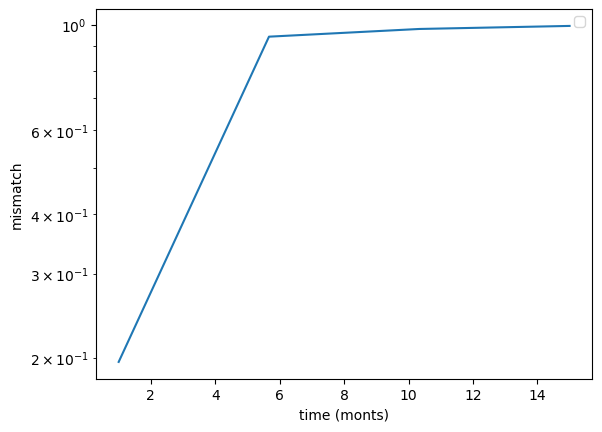

In [18]:
plt.semilogy(Trange*12,mismatch998)
plt.xlabel("time (monts)")
plt.ylabel("mismatch")
plt.legend()
plt.show()

In [34]:
### following are some mismatches: do more systematically to reproduce plots in paper!

In [35]:
1-inner_product(tdwave7, tdwave7mod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)

0.9864529921300643

In [36]:
1-inner_product(tdwave9, tdwave9mod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)

0.984574669919003

In [37]:
1-inner_product(tdwave998, tdwave998mod, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1"), normalize=True)

0.9849343006086386

## Fisher information matrix

Finally, let us construct a Fisher matrix for the intrinsic parameters 

In [28]:
pathGR = path_to_file + "/data/trajectory.txt"
kerr_gen_td_mod = KerrWaveform(trajectory_data=integrator_mod)


class StableEMRIFisher:
    
    def __init__(self, M, mu, a, p0, e0, x0, Cmod, dist, qS, phiS, qK, phiK,\
                 Phi_phi0, Phi_theta0=0.0, Phi_r0=0.0, dt = 10, T = 1,\
                 param_names=None,
                 path_to_file = path_to_file, #path to bhpwave install
                 path_to_data = path_to_file +'/data', #path to trajectory data
                 deltas=None, der_order=2, Ndelta=8, CovMat=False, CovEllipse=False, filename='', suffix=None):
        
        if param_names == None:
            raise Exception(f'param_names cannot be {param_names}')

        self.param_names = param_names

        self.path_to_file = path_to_file
        self.path_to_data = path_to_data
        #initializing FEW
        #defining model parameters

        use_gpu = False
        
        #initializing parameters
        self.M = M
        self.mu = mu
        self.a = a
        self.p0 = p0
        self.e0 = e0
        self.x0 = x0
        
        self.Cmod = Cmod
        
        self.dist = dist
        self.qS = qS
        self.phiS = phiS
        self.qK = qK
        self.phiK = phiK
        self.Phi_phi0 = Phi_phi0
        self.Phi_theta0 = Phi_theta0
        self.Phi_r0 = Phi_r0
        self.dt = dt
        self.T = T
        self.order = der_order
        self.Ndelta = Ndelta
        
        #initializing param dictionary
        self.param = {'M':M,\
                      'mu':mu,\
                      'a':a,\
                      'p0':p0,\
                      'e0':e0,\
                      'x0':x0,\
                      'dist':dist,\
                      'qS':qS,\
                      'phiS':phiS,\
                      'qK':qK,\
                      'phiK':phiK,\
                      'Phi_phi0':Phi_phi0,\
                      'Phi_theta0':Phi_theta0,\
                      'Phi_r0':Phi_r0,\
                      'Cmod':Cmod,}
        
        #initializing deltas
        self.deltas = deltas #Use deltas == None as a Flag
        
        #initializing other Flags:
        self.CovMat = CovMat
        self.CovEllipse = CovEllipse
        self.filename = filename
        self.suffix = suffix
         
    def __call__(self):
        
        #compute the waveform
        self.waveform = cp.asarray(kerr_gen_td_mod(*injection_parameters,Cmod))
        
        rho = np.sqrt(inner_product(self.waveform,self.waveform,dt=self.dt)).real
        print('Waveform Generated. SNR: ', rho)
    
        #making parent folder
        if self.filename != '':
            if not os.path.exists(self.filename):
                os.makedirs(self.filename)
        
        #Performing tasks chronologically
        
        #1. If deltas not provided, calculating the stable deltas
        if self.deltas == None:
            self.Fisher_Stability() #generates self.deltas
        
        #2. Given the deltas, we calculate the Fisher Matrix
        Fisher = self.FisherCalc()
        
        #3. If demanded, calculate the covariance Matrix
        if self.CovMat:
            covariance = np.linalg.inv(Fisher)
        else: 
            covariance = []
            
        if self.CovEllipse:
            covariance = np.linalg.inv(Fisher)
            self.CovEllipsePlot(covariance)
            
        return Fisher, covariance
    
    #Now, we define the functions being used by the class
    
    #defining the derivative function
    def derivative(self, i, delta):
        
        if self.param_names[i] == 'Cmod':
            temp = self.param.copy()
    
            temp[self.param_names[i]] += delta
            print(self.param_names[i],'=',temp[self.param_names[i]])
            
            injection_parameters = [temp['M'],
                                    temp['mu'],
                                    temp['a'],
                                    temp['p0'],
                                    temp['e0'],
                                    temp['x0'],
                                    temp['dist'],
                                    temp['qS'],
                                    temp['phiS'],
                                    temp['qK'],
                                    temp['phiK'],
                                    temp['Phi_phi0'],
                                    temp['Phi_theta0'],
                                    temp['Phi_r0'],
                                    self.dt,
                                    self.T]
    
            #compute the waveform
            waveform_plus = cp.asarray(kerr_gen_td_mod(*injection_parameters,Cmod))


            
            temp = self.param.copy()
    
            temp[self.param_names[i]] -= delta
            print(self.param_names[i],'=',temp[self.param_names[i]])
    
            injection_parameters = [temp['M'],
                                    temp['mu'],
                                    temp['a'],
                                    temp['p0'],
                                    temp['e0'],
                                    temp['x0'],
                                    temp['dist'],
                                    temp['qS'],
                                    temp['phiS'],
                                    temp['qK'],
                                    temp['phiK'],
                                    temp['Phi_phi0'],
                                    temp['Phi_theta0'],
                                    temp['Phi_r0'],
                                    self.dt,
                                    self.T]
    
            #compute the waveform
            waveform_minus = cp.asarray(kerr_gen_td_mod(*injection_parameters,Cmod))

        
            #padding waveforms with zeros in the end in case of early plunge than the original waveform
            if len(waveform_plus) < len(self.waveform):
                waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))
    
            elif len(waveform_plus) > len(self.waveform):
                waveform_plus = waveform_plus[:len(self.waveform)]
                
            if len(waveform_minus) < len(self.waveform):
                waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))
    
            elif len(waveform_minus) > len(self.waveform):
                waveform_minus = waveform_minus[:len(self.waveform)]
        
            if self.order == 2:
                             
                #2nd order finite difference differentiation
                derivative = (waveform_plus - waveform_minus)/(2*delta)
                
                del waveform_plus
                del waveform_minus
                
                return derivative

        else:
            
            temp = self.param.copy()
    
            temp[self.param_names[i]] += delta
            print(self.param_names[i],'=',temp[self.param_names[i]])
    
            injection_parameters = [temp['M'],
                                    temp['mu'],
                                    temp['a'],
                                    temp['p0'],
                                    temp['e0'],
                                    temp['x0'],
                                    temp['dist'],
                                    temp['qS'],
                                    temp['phiS'],
                                    temp['qK'],
                                    temp['phiK'],
                                    temp['Phi_phi0'],
                                    temp['Phi_theta0'],
                                    temp['Phi_r0'],
                                    self.dt,
                                    self.T]
    
            #compute the waveform
            waveform_plus = cp.asarray(kerr_gen_td_mod(*injection_parameters,Cmod))


            
            temp = self.param.copy()
    
            temp[self.param_names[i]] -= delta
            print(self.param_names[i],'=',temp[self.param_names[i]])
    
            injection_parameters = [temp['M'],
                                    temp['mu'],
                                    temp['a'],
                                    temp['p0'],
                                    temp['e0'],
                                    temp['x0'],
                                    temp['dist'],
                                    temp['qS'],
                                    temp['phiS'],
                                    temp['qK'],
                                    temp['phiK'],
                                    temp['Phi_phi0'],
                                    temp['Phi_theta0'],
                                    temp['Phi_r0'],
                                    self.dt,
                                    self.T]
    
            #compute the waveform
            waveform_minus = cp.asarray(kerr_gen_td_mod(*injection_parameters,Cmod))

        
            #padding waveforms with zeros in the end in case of early plunge than the original waveform
            if len(waveform_plus) < len(self.waveform):
                waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))
    
            elif len(waveform_plus) > len(self.waveform):
                waveform_plus = waveform_plus[:len(self.waveform)]
                
            if len(waveform_minus) < len(self.waveform):
                waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))
    
            elif len(waveform_minus) > len(self.waveform):
                waveform_minus = waveform_minus[:len(self.waveform)]
        
            if self.order == 2:
                             
                #2nd order finite difference differentiation
                derivative = (waveform_plus - waveform_minus)/(2*delta)
                
                del waveform_plus
                del waveform_minus
                
                return derivative
        
    
    #defining Fisher_Stability function, generates self.deltas
    def Fisher_Stability(self):
        print('calculating stable deltas...')
        Ndelta = self.Ndelta
        
        deltas = {}
        stability_flag = True
        unstable_params = []

        for i in range(len(self.param_names)):
            if self.param_names[i] != 'dist': #derivatives for dist can be calculated analytically
                #custom delta_inits for different parameters
                if self.param[self.param_names[i]] == 0.0:
                    delta_init = np.geomspace(1e-1,1e-8,Ndelta)
    
                elif self.param_names[i] == 'M' or self.param_names[i] == 'mu' or self.param_names[i] == 'a' or self.param_names[i] == 'p0' or self.param_names[i] == 'e0' or self.param_names[i] == 'Y0':
                    delta_init = np.geomspace(1e-4*self.param[self.param_names[i]],1e-10*self.param[self.param_names[i]],Ndelta)
                    
                else:
                    delta_init = np.geomspace(1e-1*self.param[self.param_names[i]],1e-10*self.param[self.param_names[i]],Ndelta)
    
                #sanity check:
                if self.param_names[i] == 'a' and self.param[self.param_names[i]] >= 1.:
                    self.param_names[i] = 0.999
                if self.param_names[i] == 'p0' and self.param[self.param_names[i]] <= 5:
                    self.param_names[i] = 5.0001
                if self.param_names[i] == 'e0' and self.param[self.param_names[i]] <= 0.:
                    self.param_names[i] = 1e-6
                
                Gamma = []
                #orderofmag = []
    
                for k in range(Ndelta):
                    del_k = self.derivative(i, delta_init[k])
    
                    #Calculating the Fisher Elements
                    Gammai = inner_product(del_k,del_k,dt=self.dt)
                    print(Gammai)
                    Gamma.append(Gammai)
                    relerr_flag = False
                    #if k >= 1:
                    #    relerr = np.abs(Gamma[k]-Gamma[k-1])/Gamma[k]
                    #    print(relerr)
                    #    orderofmag.append(np.floor(np.log10(relerr)))
                    #    print(orderofmag)
                    #    if k >= 2:
                    #        if orderofmag[-1] > orderofmag[-2]:
                    #            deltas[self.param_names[i]] = np.float64(delta_init[k-1])
                    #            relerr_flag = True
                    #            break
                
                if relerr_flag == False:
                    Gamma = cp.asnumpy(cp.array(Gamma))
                    relerr = np.abs(Gamma[1:] - Gamma[:-1])/Gamma[1:]
                    print(relerr)
                    relerr_min_i, = np.where(np.isclose(relerr, np.min(relerr),rtol=1e-1*np.min(relerr),atol=1e-1*np.min(relerr)))
                    if len(relerr_min_i) > 1:
                        relerr_min_i = relerr_min_i[-1]
                    print(relerr_min_i)
                    
                    if np.min(relerr) >= 0.01:
                        stability_flag = False
                        unstable_params.append(self.param_names[i])
    
                    deltas[self.param_names[i]] = np.float64(delta_init[relerr_min_i])
                
                #plt.plot(delta_init,Gamma,'ro-')
                #plt.xscale('log')
                #plt.yscale('log')
                #plt.show()
            
        print('stable deltas: ', deltas)
        
        if stability_flag == False:
            warnings.warn(f'minimum relative error is greater than 1% for {unstable_params}. Fisher may be unstable!')
            
        self.deltas = deltas
        if self.filename != '':
            if self.suffix != None:
                with open(f"{self.filename}/stable_deltas_{self.suffix}.txt", "w", newline="") as file:
                    file.write(str(deltas))
            else:
                with open(f"{self.filename}/stable_deltas.txt", "w", newline="") as file:
                    file.write(str(deltas))
        
    #defining FisherCalc function, returns Fisher
    def FisherCalc(self):
        print('calculating Fisher matrix...')
        Fisher = np.zeros((len(self.param_names),len(self.param_names)),dtype = np.float64)

        dtv = cp.zeros((len(self.param_names),len(self.waveform)),dtype=np.complex64)

        for i in range(len(self.param_names)):
            if self.param_names[i] != 'dist': #derivatives for dist can be calculated analytically
                dtv[i] = self.derivative(i, self.deltas[self.param_names[i]])
            else:
                dtv[i] = -1/self.param['dist']*cp.asarray(self.waveform)

        for i in range(len(self.param_names)):
            for j in range(i,len(self.param_names)):
                #compute the diagonal Gamma
                Fisher[i,j] = np.float64(cp.asnumpy(inner_product(dtv[i],dtv[j],dt=self.dt).real))

                #Exploiting symmetric property of the Fisher Matrix
                Fisher[j,i] = Fisher[i,j]
                
        if self.filename == '':
            pass
        else:
            if self.suffix != None:
                np.savetxt(f'{self.filename}/Fisher_{self.suffix}.txt',Fisher)
            else:
                np.savetxt(f'{self.filename}/Fisher.txt',Fisher)
                
        return Fisher

    
    #defining CovEllipsePlot function, produces Matplotlib plot
    #for the generated covariance matrix
    
    def CovEllipsePlot(self, covariance):
        print('plotting covariance ellipses...')
        
        fig, axs = plt.subplots(len(self.param_names),len(self.param_names),figsize=(20,20))

        #first param index
        for i in range(len(self.param_names)):
            #second param index
            for j in range(i,len(self.param_names)):

                if i != j:
                    cov = np.array(((covariance[i][i],covariance[i][j]),(covariance[j][i],covariance[j][j])))
                    #print(cov)
                    mean = np.array((self.param[self.param_names[i]],self.param[self.param_names[j]]))

                    cov_ellipse(mean,cov,axs[j,i],lw=2,edgecolor='blue')

                    #custom setting the x-y lim for each plot
                    axs[j,i].set_xlim([self.param[self.param_names[i]]-2.5*np.sqrt(covariance[i][i]), self.param[self.param_names[i]]+2.5*np.sqrt(covariance[i][i])])
                    axs[j,i].set_ylim([self.param[self.param_names[j]]-2.5*np.sqrt(covariance[j][j]), self.param[self.param_names[j]]+2.5*np.sqrt(covariance[j][j])])

                    axs[j,i].set_xlabel(self.param_names[i],labelpad=20,fontsize=16)
                    axs[j,i].set_ylabel(self.param_names[j],labelpad=20,fontsize=16)

                else:
                    mean = self.param[self.param_names[i]]
                    var = covariance[i][i]

                    x = np.linspace(mean-3*np.sqrt(var),mean+3*np.sqrt(var))

                    axs[j,i].plot(x,normal(mean,var,x),c='blue')
                    axs[j,i].set_xlim([self.param[self.param_names[i]]-2.5*np.sqrt(covariance[i][i]), self.param[self.param_names[i]]+2.5*np.sqrt(covariance[i][i])])
                    axs[j,i].set_xlabel(self.param_names[i],labelpad=20,fontsize=16)
                    if i == j and j == 0:
                        axs[j,i].set_ylabel(self.param_names[i],labelpad=20,fontsize=16)

        for ax in fig.get_axes():
            ax.label_outer()

        for i in range(len(self.param_names)):
            for j in range(i+1,len(self.param_names)):
                fig.delaxes(axs[i,j])
                
        if self.filename == '':
            pass
        else:
            if self.suffix != None:
                plt.savefig(f'{self.filename}/CovEllipse_{self.filename}_{suffix}.png',dpi=300,bbox_inches='tight')
            else:
                plt.savefig(f'{self.filename}/CovEllipse.png',dpi=300,bbox_inches='tight')

In [81]:
alphqnum=2**8+1
chinum=2**8+1
path_to_file = os.path.abspath("")

def waveform_model(C,M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T):
    pathname =  f"/data/trajectoryCtemp{10**6*C:.0f}ppm.txt"
    generate_mod_trajectories(C,pathname, chi_sample_num = chinum, alpha_sample_num = alphqnum)
    pathmod = path_to_file + "/data/trajectoryCtemp.txt"
    #pathGR = path_to_file + "/data/trajectory.txt"
    #trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
    trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
    #kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
    kerr_gen_td_mod = KerrWaveform(trajectory_data=trajdata_mod)
    #kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
    #kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]
    return kerr_gen_td_mod(injection_paramters)

#more general orbits
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits

#orbital phases
Phi_phi0 = 0.2 # initial azimuthal position of the secondary

#more general orbits
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits

#extrinsic binary parameters
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc

dt = 5.0  # time steps in seconds
T = 1.0  # waveform duration in years


def waveform_model_red(C,M, mu, a, p0):
    testpathname = f"/data/trajectoryCtemp{10**6*C:.0f}ppm.txt"
    pathmod = path_to_file + testpathname 
    if not os.path.isfile(pathmod):
        generate_mod_trajectories(C,testpathname, chi_sample_num = chinum, alpha_sample_num = alphqnum)
    #pathGR = path_to_file + "/data/trajectory.txt"
    #trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
    trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
    #kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
    kerr_gen_td_mod = KerrWaveform(trajectory_data=trajdata_mod)
    #kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
    #kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]   
    return kerr_gen_td_mod(*injection_paramters)

fn = np.logspace(-8, 0, 100000)
def waveform_model_fd_red(C,M, mu, a, p0):
    testpathname = f"/data/trajectoryCtemp{10**6*C:.0f}ppm.txt"
    pathmod = path_to_file + testpathname 
    if not os.path.isfile(pathmod):
        generate_mod_trajectories(C,testpathname, chi_sample_num = chinum, alpha_sample_num = alphqnum)
    #pathGR = path_to_file + "/data/trajectory.txt"
    #trajdata_GR=TrajectoryData(pathGR, dealloc_flag=False)
    trajdata_mod=TrajectoryData(pathmod, dealloc_flag=False)
    #kerr_gen_td_GR = KerrWaveform(trajectory_data=trajdata_GR)
    kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    #kerr_gen_fd_GR = KerrFrequencyWaveform(trajectory_data=trajdata_GR)
    #kerr_gen_fd_mod = KerrFrequencyWaveform(trajectory_data=trajdata_mod)
    injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]   
    return kerr_gen_fd_mod(*injection_paramters,frequencies=fn)

In [82]:
Cref=0.1
aref=0.9
#intrinsic binary
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses

#intrinsic orbital
p0 = 10 # initial semi-latus rectum


refparams = [Cref, M, mu, aref, p0, e0, x0, 
                       dist, qS, phiS, qK, phiK, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

refparamsred = [Cref, M, mu, aref, p0]

refwave=waveform_model_red(*refparamsred)
refwavefd=waveform_model_fd_red(*refparamsred)

In [83]:
rho2= inner_product(refwave, refwave, dt=dt, psd="LISASens", psd_kwargs=dict(model="scirdv1", stochastic_params=(YRSID_SI,)))
print(rho2)

/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = S

1057.2509593349985


/home/user496/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/stochastic.py:177: RuntimeWarning: divide by zero encountered in power
  * (f ** (-7.0 / 3.0))


In [88]:
rho2= inner_product(refwavefd, refwavefd, f_arr=fn, psd="LISASens", psd_kwargs=dict(model="scirdv1"))
print(rho2)

5688.545151195498


In [89]:
eps = 10**(-6)
FIM=info_matrix(eps, waveform_model_red, refparamsred,inner_product_kwargs={'dt':dt,'psd':"LISASens",'psd_kwargs':dict(model="scirdv1")})

In [94]:
eps = 10**(-6)
FIM=info_matrix(eps, waveform_model_fd_red, refparamsred,inner_product_kwargs={'f_arr':fn})

In [97]:
cov=np.linalg.inv(FIM)

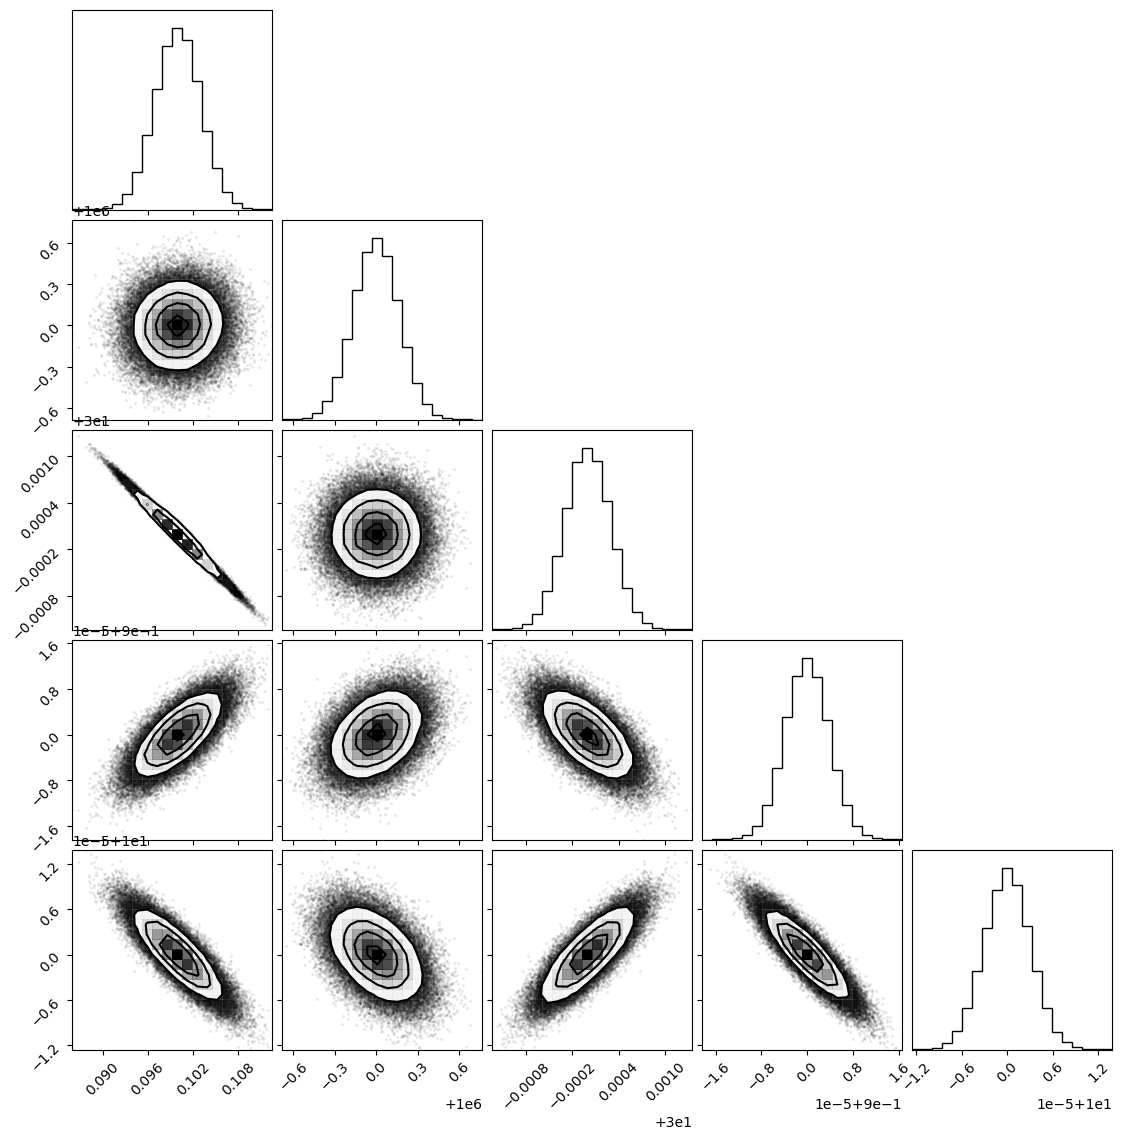

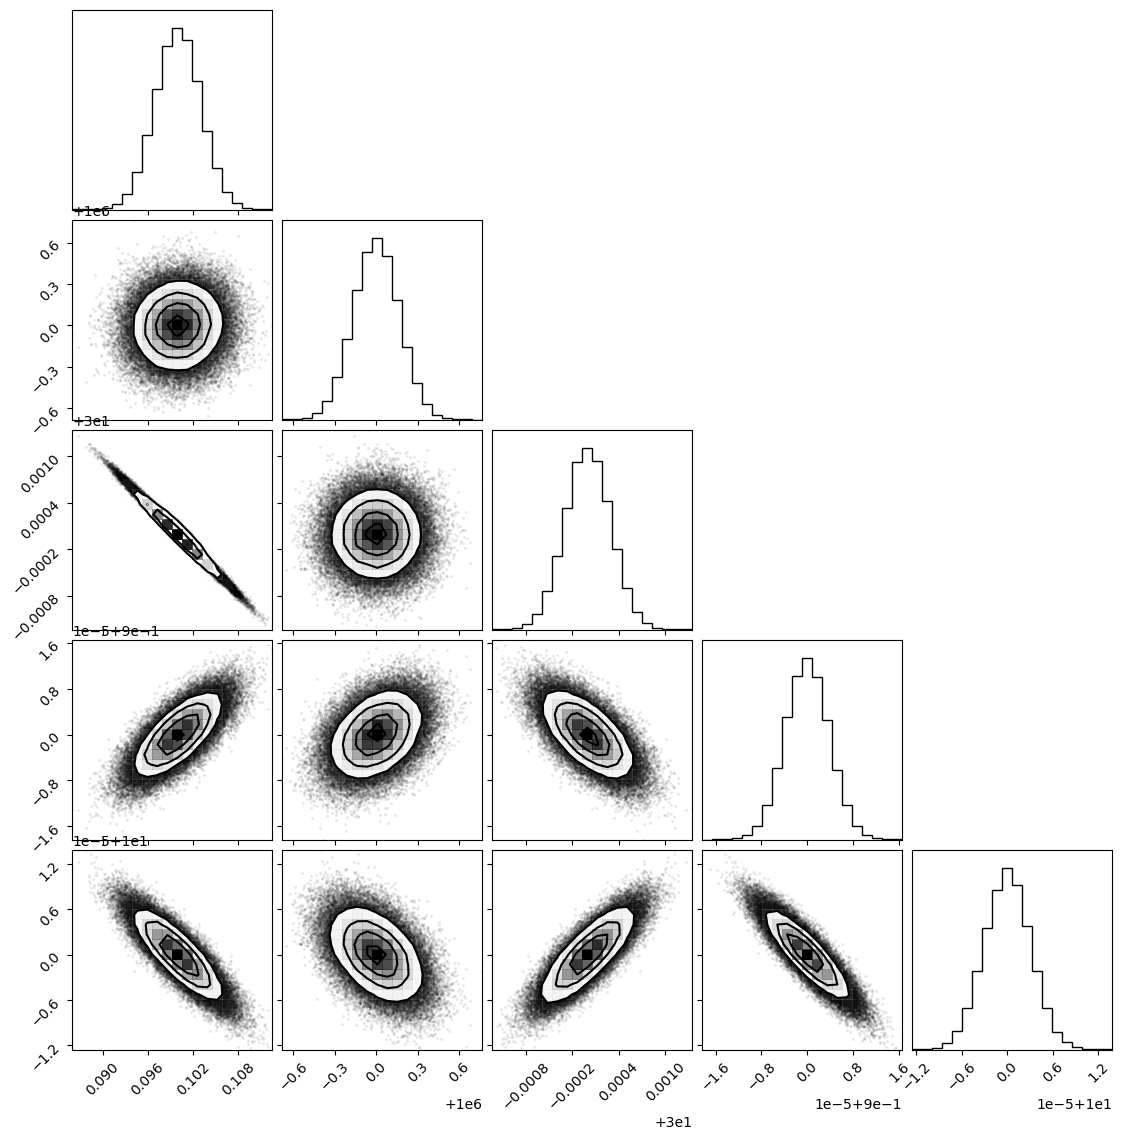

In [98]:
[Cref, M, mu, aref, p0]
plot_covariance_corner(refparamsred,cov,nsamp=100000,kwargs={'labels':['C', 'M',r'$\mu$',r'$\chi$',r'$r_0$']})